<h1 style="color:orange" align="center"> Fine Tune Vision Transformer with Medical Images</h1>

<img src="assets/h1.png">

Hugging Face is a popular open-source platform that provides a wide range of tools and libraries for working with natural language processing (NLP) and computer vision (CV) models. It offers a comprehensive ecosystem that simplifies the development and deployment of NLP and CV models.

At the core of Hugging Face is the `Transformers` library, which is designed for building, training, and fine-tuning state-of-the-art NLP models. The library supports various architectures, such as BERT, GPT, RoBERTa, and many others, which have achieved impressive performance on a wide range of NLP and CV tasks.

You can use `Transformers` library with Tensorflow. And in this notebook we are going to fine tune `google/vit-base-patch16-224-in21k` on lung and colon cancer image dataset. You can find the dataset in [Kaggle]("https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images"). It consists 25.000 images for 5 labels.

Dataset comes like this:

*lung_colon_image_set* 

        |
         - colon_image_sets
             |
              - colon_aca
              
              - colon_n
              
         - lung_image_sets
             |
              - lung_aca
              
              - lung_n
              
              - lung_scc
              
To create a labelled dataset we have to collect all the label folders under one folder. You can do this with commands.

<table><tr>
<td> <img src="lung_colon_image_set/colon_aca/colonca1.jpeg" alt="Drawing" style="width: 400;"/> </td>
<td> <img src="lung_colon_image_set/lung_aca/lungaca1.jpeg" alt="Drawing" style="width: 400;"/> </td>
</tr></table>
<h4 align="center">dataset preview</h4>

In [ ]:
# create one folder to collect label image folders
!mkdir lung_colon_folder

# copy files
!cp -R lung_colon_image_set/colon_image_sets/* lung_colon_folder
!cp -R lung_colon_image_set/lung_image_sets/* lung_colon_folder

**Vision Transformers** are a type of neural network architecture that applies the power of transformers to computer vision tasks. They break down images into smaller patches, process them using self-attention mechanisms, and capture global and local dependencies to understand the image's content and context. Vision Transformers have gained attention for their ability to handle long-range dependencies and have the potential to revolutionize computer vision by challenging the dominance of convolutional neural networks (CNNs).

We are going to fine tune Google's Vision Transformer with medical dataset.

You can find the source [here]("https://www.philschmid.de/image-classification-huggingface-transformers-keras").

In [ ]:
# install
!pip install "tensorflow==2.11.0"
!pip install transformers datasets tensorboard --upgrade
!brew install git-lfs | pip install git-lfs # to commit big files to hugginface

In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random

import time
import os

import datasets
from transformers import ViTFeatureExtractor
from tensorflow import keras
from tensorflow.keras import layers

from glob import glob

We need to login with Huggingface since we're going to push our model and metrics to hub. Go to you Huggingface main page. 

<img src="assets/ss.png">

Click on your little image in the right above. And then `Settings`. Then `Access Token`.

<img src="assets/ss2.png">

Create a new token if you didn't already or copy the existing one. And paste it to below output of the cell and let it use it for git-lfs.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Let's visualize some images.

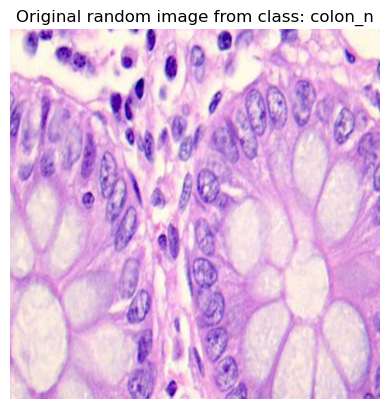

In [40]:
target_class = random.choice(os.listdir("lung_colon_image_set/")) # choose a random class
target_dir = "lung_colon_image_set/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes


In order to train our model we need this folder structure to be Huggingface dataset. We're writing a handful function to create image folder to `Dataset instance`.

In [3]:
def create_image_folder_dataset(root_path):
    """creates `Dataset` from image folder structure"""

    # get class names by folders names
    _CLASS_NAMES= os.listdir(root_path)
    # defines `datasets` features`
    features=datasets.Features({
                      "img": datasets.Image(),
                      "label": datasets.features.ClassLabel(names=_CLASS_NAMES),
                  })
    # temp list holding datapoints for creation
    img_data_files=[]
    label_data_files=[]
    # load images into list for creation
    for img_class in os.listdir(root_path):
        for img in os.listdir(os.path.join(root_path,img_class)):
            path_=os.path.join(root_path,img_class,img)
            img_data_files.append(path_)
            label_data_files.append(img_class)
    # create dataset
    ds = datasets.Dataset.from_dict({"img":img_data_files,"label":label_data_files},features=features)
    return ds

I am removing the annoying `.DS_Store` files found on MacBooks. If you are using Windows, you won't need to do this. However, these files can cause issues when processing data on Macs. If you accidentally didn't delete a file, you can come back here, delete it, and recreate the dataset instance.

In [38]:
!rm -rf lung_colon_image_set/.DS_Store
!rm -rf lung_colon_image_set/colon_aca/.DS_Store

In [5]:
cancer_ds = create_image_folder_dataset("lung_colon_image_set")

In [6]:
cancer_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 25000
})

Get class names from `Dataset` instance.

In [7]:
class_labels = cancer_ds.features["label"].names

This `model_name` is the model in [Huggingface](https://huggingface.co/google/vit-base-patch16-224-in21k). We're fetching the model and the feature extractor to use this model's blessings. This Vision Transformer (ViT) pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224.

In [8]:
model_name = "google/vit-base-patch16-224-in21k"

In [9]:
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

/Users/guldenizbektas/Documents/lung-and-colon-cancer/env/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


To facilitate model training, we must transform our 'Images' into pixel values. This task is accomplished using a 🤗 Transformers Feature Extractor, which empowers us to convert the images into a 3D array suitable for inputting into our model. This `process` will automatically create *pixel_values*.

In [10]:
def process(images):
    images.update(feature_extractor(images["img"], ))
    return images

In [11]:
cancer_ds = cancer_ds.rename_column("label", "labels")

If you think you can use all 25000 images because of memory issues you can split them. In Kaggle and Google Colab you'll get memory error in the `process` part. Even if you split it for like 1000 images per class you won't be able to start training due to memory. So you can use 200 images per label. I trained this with whole dataset in M1 Pro Macbook. It took like 5 hours for 5 epoch.

In [12]:
processed_dataset = cancer_ds.map(process, batched=True)
processed_dataset

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Dataset({
    features: ['img', 'labels', 'pixel_values'],
    num_rows: 25000
})

In [13]:
# test size will be 15% of train dataset
test_size=.15

processed_dataset = processed_dataset.shuffle().train_test_split(test_size=test_size)

Once our dataset is processed, we can proceed to download the pretrained model and perform fine-tuning. However, before we can proceed, we need to convert our Hugging Face datasets Dataset into a `tf.data.Dataset`since we're going to use Tensorflow for training. To achieve this, we will utilize the `.to_tf_dataset` method.

### What is Data Collator?

A data collator is an object used in machine learning pipelines, particularly in the context of training deep learning models. Its primary purpose is to take a list of dataset elements and organize them into batches, which can then be efficiently processed during model training.

The role of a data collator is crucial in scenarios where the input data is not uniformly sized or requires additional preprocessing before being fed into the model. 

Also Data Collator dynamically pad the inputs received, as well as the labels. We're gonna use that in here.

In [14]:
from huggingface_hub import HfFolder
import tensorflow as tf

id2label = {str(i): label for i, label in enumerate(class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 5
train_batch_size = 32
eval_batch_size = 32
learning_rate = 3e-5
weight_decay_rate=0.01
num_warmup_steps=0
output_dir=model_name.split("/")[1]
hub_token = HfFolder.get_token() # or your token directly "hf_xxx"
hub_model_id = f'{model_name.split("/")[1]}-lung_and_colon' # this is your model name in huggingface, create first
fp16=False # set to True if you have a GPU

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")


Here we're converting to `tf.Dataset`.

In [15]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")

# converting our train dataset to tf.data.Dataset
tf_train_dataset = processed_dataset["train"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=train_batch_size,
   collate_fn=data_collator)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = processed_dataset["test"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=eval_batch_size,
   collate_fn=data_collator)

Metal device set to: Apple M1 Pro


Downloading pre-trained model with `TFViTForImageClassification` class.

### What is top-3-accuracy?

Top-3 accuracy is an evaluation metric commonly used in multi-class classification tasks. It measures the percentage of predictions where the correct label appears in the top three predicted classes.

To calculate the top-3 accuracy, the model's predicted probabilities for each class are ranked, and the top three classes with the highest probabilities are considered. If the true label (the ground truth) is among these top three predictions, it is counted as a correct prediction.

Top-3 accuracy is a more forgiving metric than traditional accuracy because it allows for some flexibility in predicting the correct class. It accounts for cases where the model might have made a mistake in assigning the highest probability to the true class but still predicted some of the other relevant classes.

This metric is particularly useful in scenarios where the order of importance or relevance among the predicted classes is not well-defined, or when there are multiple valid correct answers for a given input. By considering the top three predictions, it provides a more lenient evaluation measure that reflects a broader understanding of the model's performance.

In [16]:
from transformers import TFViTForImageClassification, create_optimizer
import tensorflow as tf

# create optimizer wight weigh decay
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
model = TFViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_labels),
    id2label=id2label,
    label2id=label2id,
)

# define loss
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# define metrics
metrics=[
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

# compile model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kernel:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We will push the Tensorboard logs alongside the weights to the Hub, enabling us to utilize the "Training Metrics" feature for real-time monitoring of our training performance. We're adding some callbacks like `EarlyStopping`. The training process will monitor the "val_accuracy" metric and terminate the training when it fails to show any improvement beyond a certain patience value, which is 1 for this case. So, since we're finetuning a model we're likely get good results, 1 is the ideal patience.

In [17]:
import os
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping

callbacks=[]

callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir,"logs")))
callbacks.append(EarlyStopping(monitor="val_accuracy",patience=1))
if hub_token:
    callbacks.append(PushToHubCallback(output_dir=output_dir,
                                     hub_model_id=hub_model_id,
                                     hub_token=hub_token))



/Users/guldenizbektas/Documents/lung-and-colon-cancer/vit-base-patch16-224-in21k is already a clone of https://huggingface.co/Guldeniz/vit-base-patch16-224-in21k-lung_and_colon. Make sure you pull the latest changes with `repo.git_pull()`.


It will take a looooooong time. Feature extractor does not suppot `push_to_hub`. You'll need to upload files manually to Hub. But we'll add `preprocessor_config.json` file. 

In [18]:
train_results = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=callbacks,
    epochs=num_train_epochs,
)

Epoch 1/5


2023-05-25 09:50:19.582624: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


665/665 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9784 - top-3-accuracy: 0.9985

Several commits (4) will be pushed upstream.


665/665 [==============================] - 1293s 2s/step - loss: 0.1870 - accuracy: 0.9784 - top-3-accuracy: 0.9985 - val_loss: 0.0455 - val_accuracy: 0.9987 - val_top-3-accuracy: 1.0000
Epoch 2/5
665/665 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9972 - top-3-accuracy: 1.0000

Several commits (5) will be pushed upstream.


665/665 [==============================] - 1294s 2s/step - loss: 0.0345 - accuracy: 0.9972 - top-3-accuracy: 1.0000 - val_loss: 0.0189 - val_accuracy: 0.9995 - val_top-3-accuracy: 1.0000
Epoch 3/5
665/665 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 1.0000 - top-3-accuracy: 1.0000

Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.
Several commits (6) will be pushed upstream.


665/665 [==============================] - 1315s 2s/step - loss: 0.0134 - accuracy: 1.0000 - top-3-accuracy: 1.0000 - val_loss: 0.0110 - val_accuracy: 0.9997 - val_top-3-accuracy: 1.0000
Epoch 4/5
665/665 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 1.0000 - top-3-accuracy: 1.0000

Several commits (7) will be pushed upstream.


665/665 [==============================] - 1324s 2s/step - loss: 0.0088 - accuracy: 1.0000 - top-3-accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 0.9997 - val_top-3-accuracy: 1.0000


In [19]:
feature_extractor.save_pretrained(output_dir)

['vit-base-patch16-224-in21k/preprocessor_config.json']

This code will send `preprocessor_config.json` to your model Hub.

In [21]:
from huggingface_hub import HfApi

api = HfApi()

user = api.whoami(hub_token)


api.upload_file(
    token=hub_token,
    repo_id=f"{user['name']}/{hub_model_id}",
    path_or_fileobj=os.path.join(output_dir,"preprocessor_config.json"),
    path_in_repo="preprocessor_config.json",
    create_pr=1
)


'https://huggingface.co/Guldeniz/vit-base-patch16-224-in21k-lung_and_colon/blob/refs%2Fpr%2F1/preprocessor_config.json'

When you add these files to Hub it will look like this:

In [41]:
!ls vit-base-patch16-224-in21k/

README.md                logs                     tf_model.h5
config.json              preprocessor_config.json


<img src="assets/files.png"></img>

And the logs:

<img src="assets/metrics.png"></img>